# CCPP Analysis

Analysis of the CCPP weather data as part of the class assignment for the Coursera course "AI for Product Managers".

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [292]:
df = pd.read_csv("data/ccpp_data.csv")
df.head(4)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48


In [293]:
# Gathering information of the data within the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [294]:
# Check for 'null' values
print(df.isnull().sum())

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


### Step 1 - Type of ML approach and output metric
For the problem described in the Project Topic section above, determine what type of machine learning approach is needed and select an appropriate output metric to evaluate performance in accomplishing the task.

**Solutions:**
1) Type of ML approach:<br>
   In order to predict our target parameters (here the energy production (PE)), and because of the availability of existing target data, a supervised learning approach could be beneficial. Considering the available options in terms of predicting a possible solution, a **regression**/**linear regression** could be used in this analysis. 
2) Output metric:<br>
   In the case of power prediction, an output metric which is more robust to outliers could be beneficial. Here, the regression error metrics including the mean squared error (**MSE**), the mean absolute error (**MAE**), the mean absolute percentage error (**MAPE**) and $R^2$ will be used. Beside a good interpretability, the MAE manage to minimize the huge outliers.

### Step 2 - Feature selection and algorithm selection

Determine which possible features we may want to use in the model, and identify the different algorithms we might consider.

**Solutions:**
1) **Feature Evaluation**:<br>To determine the most capable features for training the model, a plot of the feature against the output target is beneficial. By looking at the distribution of the points, we could see a potential correlation, which the final model could learn and understand. Regarding the different plots, we could identify, that the correlation between the temperature (AT) as well as the exhaust vacuum (V) and the energy production are the strongest ones. So, the AT and the V columns should be the best fitting features for our model to train.
2) **Algorithm Evaluation**:<br> In terms of regressions, and the goal to predict our target and not classify it, the Ridge Regression as well as the Lasso Regression should be considered. Afterwards, both models will be used to make measurements in case of feature importance. 

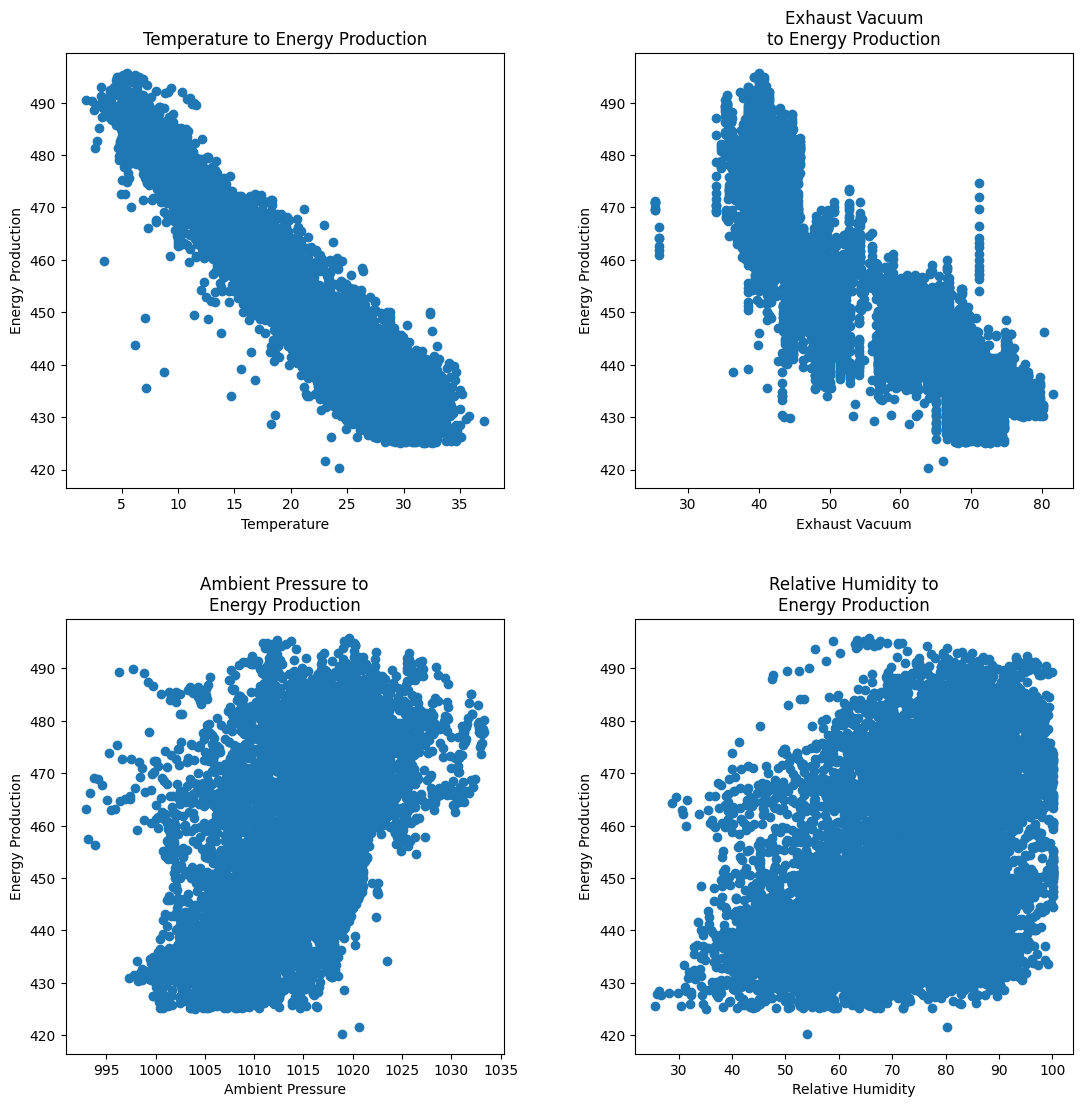

In [295]:
figure, axis = plt.subplots(2,2,figsize=(13,13))
figure.subplots_adjust(wspace=0.3,hspace=0.3)

axis[0,0].scatter(df["AT"],df["PE"])
axis[0,0].set_title("Temperature to Energy Production")
axis[0,0].set_xlabel("Temperature")
axis[0,0].set_ylabel("Energy Production")

axis[0,1].scatter(df["V"],df["PE"])
axis[0,1].set_title("Exhaust Vacuum\nto Energy Production")
axis[0,1].set_xlabel("Exhaust Vacuum")
axis[0,1].set_ylabel("Energy Production")

axis[1,0].scatter(df["AP"],df["PE"])
axis[1,0].set_title("Ambient Pressure to\nEnergy Production")
axis[1,0].set_xlabel("Ambient Pressure")
axis[1,0].set_ylabel("Energy Production")

axis[1,1].scatter(df["RH"],df["PE"])
axis[1,1].set_title("Relative Humidity to\nEnergy Production")
axis[1,1].set_xlabel("Relative Humidity")
axis[1,1].set_ylabel("Energy Production")
plt.show()

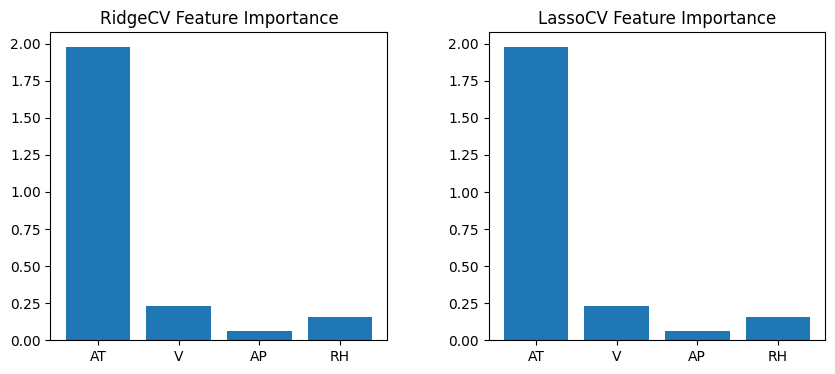

In [296]:
X = df[df.columns[:-1].array]
y = df[df.columns[-1]]

ridge = RidgeCV(alphas=np.logspace(-6,6, num=5)).fit(X,y)
lasso = LassoCV(alphas=np.logspace(-6,6, num=5)).fit(X,y)

importance_ridge = np.abs(ridge.coef_)
importance_lasso = np.abs(lasso.coef_)

feature_names = np.array(df.columns[:-1].array)

figure, axis = plt.subplots(1,2,figsize=(10,4))
figure.subplots_adjust(wspace=0.3)
axis[0].bar(height=importance_ridge, x=feature_names)
axis[0].set_title("RidgeCV Feature Importance")
axis[1].bar(height=importance_lasso, x=feature_names)
axis[1].set_title("LassoCV Feature Importance")

plt.show()

#### Automated Feature Selection
Beside the manual feature selection using the graphical representations of the coefficients, scikit-learn allows the automated selection of the formerly calculated feature importance. The result is the same as the manual selection. So this could serve as validation for choosing the right features for the later training.

In [297]:
# Automated feature selection
threshold = np.sort(importance_ridge)[-3] + 0.01

sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
selected_features = feature_names[sfm.get_support()]
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['AT' 'V']


### Step 3 - Dataset splitting and validation strategy

Split your data to create a test set to evaluate the performance of your final model.  Then, using your training set, determine a validation strategy for comparing different models - a fixed validation set or cross-validation.  Depending on whether you are using Excel, Python or AutoML for your model building, you may need to manually split your data to create the test set and validation set / cross validation folds.

**Solutions:**
1) Dataset splitting: In order to split the underlying dataset with the selected features ['AT' 'V'], the `train_test_split` function as part of the scikit-learn framework is used. As test size, 30% of the original dataset and a randomness regarding data shuffling of 10 is chosen. This allows a more reproducible outcome of the training.
2) Validation strategy: As validation strategy for choosing the best model, the method of k-fold cross-validation is selected. As part of the linear models in scikit-learn `LassoCV` and `RidgeCV`, the provided methods for determining the validation folds could be used here.

In [298]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X[selected_features],y, test_size=0.3,random_state=10)

### Step 4 - Validation approach 

Use your validation approach to compare at least two different models (which may be either 
1) different algorithms, 
2) the same algorithm with different combinations of features, or 
3) the same algorithm and features with different values for hyperparameters).

From among the models you compare, select the model with the best performance on your validation set as your final model.

In [299]:
# Ridge Regression
lasso_model = LassoCV(alphas=np.logspace(-6,6, num=5),
                      cv=5, 
                      random_state=0, 
                      max_iter=10000).fit(X_train,y_train)

# Choose best model of lasso regression
lasso_best = Lasso(alpha=lasso_model.alpha_)
lasso_best.fit(X_train,y_train)

# Perform MSE test for train and test data
print("[Lasso Regression] R squared on training set is {} %".format(round(lasso_best.score(X_train, y_train)*100, 2)))
print("[Lasso Regression] R squared on test set {} %".format(round(lasso_best.score(X_test, y_test)*100, 2)))

pred_train = lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print("[Lasso Regression] MSE training set", round(mse_train, 2))
pred_test = lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, pred_test)
print("[Lasso Regression] MSE test set", round(mse_test, 2))

[Lasso Regression] R squared on training set is 91.44 %
[Lasso Regression] R squared on test set 91.88 %
[Lasso Regression] MSE training set 24.75
[Lasso Regression] MSE test set 24.07


In [300]:
# Ridge Cross Validation Class
ridge_model = RidgeCV(alphas=np.logspace(-6,6, num=5),
                      cv=5).fit(X_train, y_train)
# Choose best model of ridge regression
ridge_best = Ridge(alpha=ridge_model.alpha_)
ridge_best.fit(X_train,y_train)


Ridge()

### Step 5 - Model evaluation

Evaluate the performance of your final model using the output metric you defined earlier. 

In [301]:
pred_train = ridge_best.predict(X_train)
pred_test = ridge_best.predict(X_test)

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
mape_train = mean_absolute_percentage_error(y_train, pred_train)
mape_test = mean_absolute_percentage_error(y_test, pred_test)

print("[Ridge Regression] R squared training set {} %".format(round(ridge_best.score(X_train, y_train)*100, 2)))
print("[Ridge Regression] R squared test set {} %".format(round(ridge_best.score(X_test, y_test)*100, 2)))
print("[Ridge Regression] MSE training set", round(mse_train, 2))
print("[Ridge Regression] MSE test set", round(mse_test, 2))
print("[Ridge Regression] MAE training set", round(mae_train, 2))
print("[Ridge Regression] MAE test set", round(mae_test, 2))
print("[Ridge Regression] MAPE training set {}%".format(round(mape_train, 2)*100))
print("[Ridge Regression] MAPE test set {}%".format(round(mape_test, 2)*100))

[Ridge Regression] R squared training set 91.44 %
[Ridge Regression] R squared test set 91.88 %
[Ridge Regression] MSE training set 24.75
[Ridge Regression] MSE test set 24.07
[Ridge Regression] MAE training set 3.92
[Ridge Regression] MAE test set 3.92
[Ridge Regression] MAPE training set 1.0%
[Ridge Regression] MAPE test set 1.0%


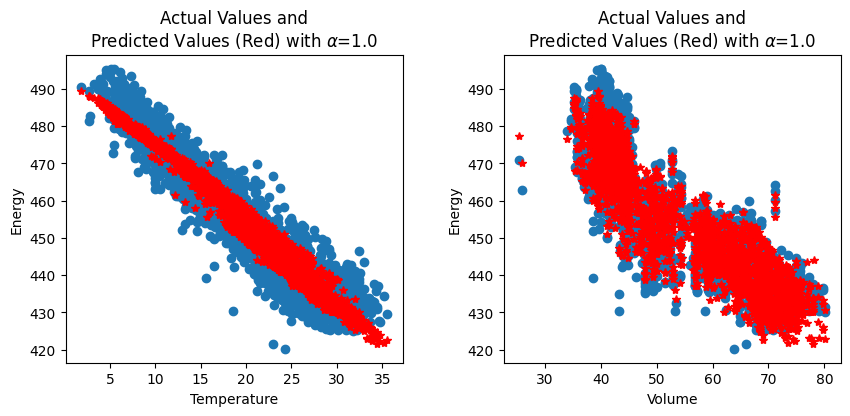

In [302]:
figure, axis = plt.subplots(1,2,figsize=(10,4))
figure.subplots_adjust(wspace=0.3)

axis[0].scatter(X_test["AT"],y_test)
axis[0].plot(X_test["AT"], pred_test, "*", color="red")
axis[0].set_xlabel("Temperature")
axis[0].set_ylabel("Energy")
axis[0].set_title("Actual Values and\nPredicted Values (Red)" + r" with $\alpha$={}".format(ridge_best.alpha))
axis[1].scatter(X_test["V"],y_test)
axis[1].plot(X_test["V"],pred_test, "*", color="red")
axis[1].set_xlabel("Volume")
axis[1].set_ylabel("Energy")
axis[1].set_title("Actual Values and\nPredicted Values (Red)" + r" with $\alpha$={}".format(ridge_best.alpha))
plt.show()

## (Optional) Step 6 - Simple Linear Regression
Additionally, a linear regression using the least square linear regression is used to predict to power outcome. Therefore, the training and test splits are divided per feature and a separate regression model is trained.

In [303]:
regr_at = linear_model.LinearRegression() # Least square linear regression
regr_v = linear_model.LinearRegression() # Least square linear regression
X_at_train = np.array(X_train["AT"]).reshape(-1,1)
X_v_train = np.array(X_train["V"]).reshape(-1,1)

regr_at.fit(X_at_train, y_train)
regr_v.fit(X_v_train, y_train)

pred_at_train = regr_at.predict(X_at_train)
pred_v_train = regr_v.predict(X_v_train)

mse_at_train = mean_squared_error(y_train, pred_at_train)
mae_at_train = mean_absolute_error(y_train, pred_at_train)
mape_at_train = mean_absolute_percentage_error(y_train, pred_at_train)
mse_v_train = mean_squared_error(y_train, pred_v_train)
mae_v_train = mean_absolute_error(y_train, pred_v_train)
mape_v_train = mean_absolute_percentage_error(y_train, pred_v_train)

X_at_test = np.array(X_test["AT"]).reshape(-1,1)
X_v_test = np.array(X_test["V"]).reshape(-1,1)

pred_at_test = regr_at.predict(X_at_test)
pred_v_test = regr_v.predict(X_v_test)

mse_at_test = mean_squared_error(y_test, pred_at_test)
mae_at_test = mean_absolute_error(y_test, pred_at_test)
mape_at_test = mean_absolute_percentage_error(y_test, pred_at_test)
mse_v_test = mean_squared_error(y_test, pred_v_test)
mae_v_test = mean_absolute_error(y_test, pred_v_test)
mape_v_test = mean_absolute_percentage_error(y_test, pred_v_test)

print("[Linear Regression Temperature] MSE training set", round(mse_at_train, 2))
print("[Linear Regression Temperature] MSE test set", round(mse_at_test, 2))
print("[Linear Regression Temperature] MAE training set", round(mae_at_train, 2))
print("[Linear Regression Temperature] MAE test set", round(mae_at_test, 2))
print("[Linear Regression Temperature] MAPE training set", round(mape_at_train, 2)*100, "%")
print("[Linear Regression Temperature] MAPE test set", round(mape_at_test, 2)*100, "%")
print("[Linear Regression Temperature] R squared training set {} %".format(round(regr_at.score(X_at_train, y_train)*100, 2)))
print("[Linear Regression Temperature] R squared training set {} %\n".format(round(regr_at.score(X_at_test, y_test)*100, 2)))

print("[Linear Regression Vacuum] MSE training set", round(mse_v_train, 2))
print("[Linear Regression Vacuum] MSE test set", round(mse_v_test, 2))
print("[Linear Regression Vacuum] MAE training set", round(mae_v_train, 2))
print("[Linear Regression Vacuum] MAE test set", round(mae_v_test, 2))
print("[Linear Regression Vacuum] MAPE training set", round(mape_v_train)*100, "%")
print("[Linear Regression Vacuum] MAPE test set", round(mape_v_test, 2)*100, "%")
print("[Linear Regression Vacuum] R squared training set {} %".format(round(regr_v.score(X_v_train, y_train)*100, 2)))
print("[Linear Regression Vacuum] R squared training set {} %".format(round(regr_v.score(X_v_test, y_test)*100, 2)))


[Linear Regression Temperature] MSE training set 29.79
[Linear Regression Temperature] MSE test set 28.6
[Linear Regression Temperature] MAE training set 4.3
[Linear Regression Temperature] MAE test set 4.27
[Linear Regression Temperature] MAPE training set 1.0 %
[Linear Regression Temperature] MAPE test set 1.0 %
[Linear Regression Temperature] R squared training set 89.69 %
[Linear Regression Temperature] R squared training set 90.35 %

[Linear Regression Vacuum] MSE training set 71.06
[Linear Regression Vacuum] MSE test set 70.64
[Linear Regression Vacuum] MAE training set 6.57
[Linear Regression Vacuum] MAE test set 6.58
[Linear Regression Vacuum] MAPE training set 0 %
[Linear Regression Vacuum] MAPE test set 1.0 %
[Linear Regression Vacuum] R squared training set 75.41 %
[Linear Regression Vacuum] R squared training set 76.16 %


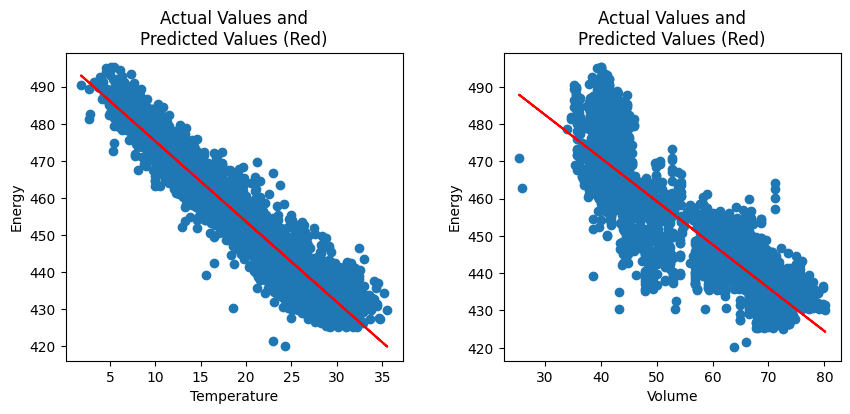

In [304]:
figure, axis = plt.subplots(1,2,figsize=(10,4))
figure.subplots_adjust(wspace=0.3)

axis[0].scatter(X_at_test,y_test)
axis[0].plot(X_at_test, pred_at_test, color="red",label="Reg AT")
axis[0].set_xlabel("Temperature")
axis[0].set_ylabel("Energy")
axis[0].set_title("Actual Values and\nPredicted Values (Red)")
axis[1].scatter(X_v_test,y_test)
axis[1].plot(X_v_test, pred_v_test, color="red",label="Reg V")
axis[1].set_xlabel("Volume")
axis[1].set_ylabel("Energy")
axis[1].set_title("Actual Values and\nPredicted Values (Red)")
plt.show()